In [12]:
import numpy as np
import pandas as pd
import geopandas as gpd
import igraph as ig
from pathlib import Path
from tqdm import tqdm
import os
import datetime

from matplotlib import pyplot as plt
import matplotlib.dates as mdates
from matplotlib import rcParams
params = {
    'axes.labelsize': 20,
    'axes.titlepad': 15,
    'axes.titlesize': 24,
    'font.size': 20,
    'legend.fontsize': 14,
    'axes.labelsize' : 18,
    'text.usetex': False,
    'figure.figsize': [5,5],
    'axes.labelpad' : 16,
    'lines.linewidth' : 2,
    "figure.edgecolor": "black",
    'axes.linewidth':2,
    'xtick.major.pad':6,
    'ytick.major.pad':6,
    'xtick.minor.pad':6,
    'ytick.minor.pad':6
}
rcParams['agg.path.chunksize'] = 10000
rcParams.update(params)

import contextily as cx

# Load reference graphs

In [13]:
GRAPHS_BASE_PATH = Path("/home/rico/Documents/thesis/experiments/historical_data_ams/size_only_graphs/")
ref_ams_pt_2019 = ig.read(GRAPHS_BASE_PATH.joinpath("ams_2019/resulting_graph/Amsterdam_pt_network_monday_20190103_20190804.gml"))
ref_ams_pt_2020 = ig.read(GRAPHS_BASE_PATH.joinpath("ams_2020/resulting_graph/Amsterdam_pt_network_monday_20191230_20200802.gml"))
ref_ams_pt_2021 = ig.read(GRAPHS_BASE_PATH.joinpath("ams_2021/resulting_graph/Amsterdam_pt_network_monday_20210103_20210808.gml"))

In [14]:
ref_n_edges_len_2019 = len(ref_ams_pt_2019.es.select(type_ne='walk'))
ref_n_edges_len_2020 = len(ref_ams_pt_2020.es.select(type_ne='walk'))
ref_n_edges_len_2021 = len(ref_ams_pt_2021.es.select(type_ne='walk'))
print(f"Graph size of Amsterdam in 2019: {ref_n_edges_len_2019}")
print(f"Graph size of Amsterdam in 2020: {ref_n_edges_len_2020}")
print(f"Graph size of Amsterdam in 2021: {ref_n_edges_len_2021}")

Graph size of Amsterdam in 2019: 1853
Graph size of Amsterdam in 2020: 1803
Graph size of Amsterdam in 2021: 1611


In [15]:
ref_complete_stats = pd.read_csv("/home/rico/Documents/thesis/eda/notebooks/reference_results/complete_stats.csv")
ref_inequalities = pd.read_csv("/home/rico/Documents/thesis/eda/notebooks/reference_results/inequalities.csv")
ref_nw_to_w_trend = pd.read_csv("/home/rico/Documents/thesis/eda/notebooks/reference_results/nw_to_w_trend.csv")

ref_complete_stats['date'] = pd.to_datetime(ref_complete_stats['date'])
ref_inequalities['date'] = pd.to_datetime(ref_inequalities['date'])
ref_nw_to_w_trend['date'] = pd.to_datetime(ref_nw_to_w_trend['date'])

ref_complete_stats['year'] = pd.DatetimeIndex(ref_complete_stats.date).year
ref_inequalities['year'] = pd.DatetimeIndex(ref_inequalities.date).year
ref_nw_to_w_trend['year'] = pd.DatetimeIndex(ref_nw_to_w_trend.date).year

ref_complete_stats['month'] = pd.DatetimeIndex(ref_complete_stats.date).month
ref_inequalities['month'] = pd.DatetimeIndex(ref_inequalities.date).month
ref_nw_to_w_trend['month'] = pd.DatetimeIndex(ref_nw_to_w_trend.date).month

ref_complete_stats['quarter'] = pd.DatetimeIndex(ref_complete_stats.date).quarter
ref_inequalities['quarter'] = pd.DatetimeIndex(ref_inequalities.date).quarter
ref_nw_to_w_trend['quarter'] = pd.DatetimeIndex(ref_nw_to_w_trend.date).quarter

In [16]:
ref_graph_sizes_df = pd.DataFrame([{'date': ref_inequalities['date'].unique()[0], 'size': ref_n_edges_len_2019},
                                   {'date': ref_inequalities['date'].unique()[1], 'size': ref_n_edges_len_2020},
                                   {'date': ref_inequalities['date'].unique()[2], 'size': ref_n_edges_len_2021},
                                   ], columns=['date', 'size'])
ref_graph_sizes_df['date'] = pd.to_datetime(ref_graph_sizes_df['date'])
ref_graph_sizes_df.head()

,date,size
0,2019-01-03,1853
1,2020-12-30,1803
2,2021-01-03,1611


In [17]:
ref_complete_stats = pd.merge(ref_complete_stats, ref_graph_sizes_df, how='left', on='date')
ref_inequalities = pd.merge(ref_inequalities, ref_graph_sizes_df, how='left', on='date')
ref_nw_to_w_trend = pd.merge(ref_nw_to_w_trend, ref_graph_sizes_df, how='left', on='date')

# Compute graph sizes

In [18]:
GRAPH_DATA_DIR = Path("/home/rico/Documents/thesis/eda/notebooks/sample_data/transit_graphs")
graph_folders = [d for d in os.listdir(GRAPH_DATA_DIR) if os.path.isdir(GRAPH_DATA_DIR.joinpath(d))]
graphs = [GRAPH_DATA_DIR.joinpath(folder).joinpath(file) for folder in graph_folders for file in
          os.listdir(GRAPH_DATA_DIR.joinpath(folder)) if Path(file).suffix == '.gml']
ams_nb = gpd.read_file('/home/rico/Documents/thesis/eda/notebooks/sample_data/amsterdam/ams-neighbourhoods.geojson')

In [19]:
graphs[:5]

[PosixPath('/home/rico/Documents/thesis/eda/notebooks/sample_data/transit_graphs/filtered-ov-gtfs-20210201/ams_pt_network_monday_20210201.gml'),
 PosixPath('/home/rico/Documents/thesis/eda/notebooks/sample_data/transit_graphs/filtered-ov-gtfs-20200203/ams_pt_network_monday_20200203.gml'),
 PosixPath('/home/rico/Documents/thesis/eda/notebooks/sample_data/transit_graphs/filtered-ov-gtfs-20190923/ams_pt_network_monday_20190923.gml'),
 PosixPath('/home/rico/Documents/thesis/eda/notebooks/sample_data/transit_graphs/filtered-ov-gtfs-20210726/ams_pt_network_monday_20210726.gml'),
 PosixPath('/home/rico/Documents/thesis/eda/notebooks/sample_data/transit_graphs/filtered-ov-gtfs-20191223/ams_pt_network_monday_20191223.gml')]

In [20]:
date_extractor = lambda x: x.name.removesuffix('.gml').split('_')[-1]
date_converter = lambda x: x[0:4] + '-' + x[4:6] + '-' + x[6:9]
dates = [datetime.date.fromisoformat(date_converter(date_extractor(p))) for p in graphs]

In [21]:
graph_sizes = {}

for k, g in enumerate(tqdm(graphs)):
    # Read the transit network
    G_transit = ig.read(g)
    graph_sizes[dates[k]] = len(G_transit.es)

100%|██████████| 156/156 [00:09<00:00, 15.71it/s]


In [22]:
sorted_date_graph_size = {}

for k in sorted(graph_sizes.keys()):
    sorted_date_graph_size[k] = graph_sizes[k]

In [23]:
graph_sizes_df = pd.DataFrame(sorted_date_graph_size.items(), columns=['date', 'size'])
graph_sizes_df['date'] = pd.to_datetime(graph_sizes_df['date'])
graph_sizes_df

,date,size
0,2019-01-07,1517
1,2019-01-14,1517
2,2019-01-21,1517
3,2019-01-28,1513
4,2019-02-04,1517
...,...,...
151,2021-11-29,1395
152,2021-12-06,1396
153,2021-12-13,1387
154,2021-12-20,1382


<AxesSubplot:>

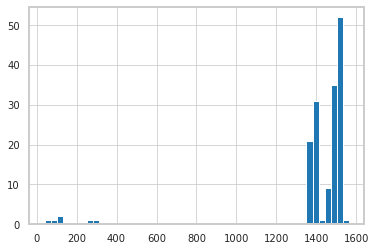

In [24]:
graph_sizes_df['size'].hist(bins=50)

# Merge with inequality data

In [25]:
complete_stats = pd.read_csv("/home/rico/Documents/thesis/eda/notebooks/results/complete_stats.csv")
inequalities = pd.read_csv("/home/rico/Documents/thesis/eda/notebooks/results/inequalities.csv")
nw_to_w_trend = pd.read_csv("/home/rico/Documents/thesis/eda/notebooks/results/nw_to_w_trend.csv")

In [26]:
complete_stats['date'] = pd.to_datetime(complete_stats['date'])
inequalities['date'] = pd.to_datetime(inequalities['date'])
nw_to_w_trend['date'] =  pd.to_datetime(nw_to_w_trend['date'])

complete_stats['year'] = pd.DatetimeIndex(complete_stats.date).year
inequalities['year'] = pd.DatetimeIndex(inequalities.date).year
nw_to_w_trend['year'] = pd.DatetimeIndex(nw_to_w_trend.date).year

complete_stats['month'] = pd.DatetimeIndex(complete_stats.date).month
inequalities['month'] = pd.DatetimeIndex(inequalities.date).month
nw_to_w_trend['month'] = pd.DatetimeIndex(nw_to_w_trend.date).month

complete_stats['quarter'] = pd.DatetimeIndex(complete_stats.date).quarter
inequalities['quarter'] = pd.DatetimeIndex(inequalities.date).quarter
nw_to_w_trend['quarter'] = pd.DatetimeIndex(nw_to_w_trend.date).quarter

In [27]:
del complete_stats['Unnamed: 0']
del inequalities['Unnamed: 0']
del nw_to_w_trend['Unnamed: 0']

complete_stats = complete_stats.set_index('date')
inequalities = inequalities.set_index('date')
nw_to_w_trend = nw_to_w_trend.set_index('date')

complete_stats = complete_stats.sort_index()
inequalities = inequalities.sort_index()
nw_to_w_trend = nw_to_w_trend.sort_index()

In [28]:
complete_stats = pd.merge(complete_stats, graph_sizes_df, how='left', on='date')
inequalities = pd.merge(inequalities, graph_sizes_df, how='left', on='date')
nw_to_w_trend = pd.merge(nw_to_w_trend, graph_sizes_df, how='left', on='date')

In [29]:
complete_stats = complete_stats[complete_stats['size'] > 1000]
inequalities = inequalities[inequalities['size'] > 1000]
nw_to_w_trend = nw_to_w_trend[nw_to_w_trend['size'] > 1000]

In [30]:
complete_stats.head()

,date,metric,BU03630000,BU03630001,BU03630002,BU03630003,BU03630004,BU03630100,BU03630101,BU03630102,...,BU03639702,BU03639703,BU03639800,BU03639801,BU03631003,BU03631005,year,month,quarter,size
0,2019-01-07,thr_15min_pois,229.000000,312.000000,363.000000,376.000000,334.000000,4.000000,275.000000,281.000000,...,46.000000,59.000000,29.000000,9.000000,NaN,NaN,2019,1,1,1517
1,2019-01-07,avg_hops,11.437553,10.591837,10.948762,10.350215,10.350215,5.312500,11.129582,11.129582,...,24.989761,23.487223,19.720613,19.720613,NaN,NaN,2019,1,1,1517
2,2019-01-07,avg_lines,3.966865,3.719388,4.185312,3.952790,3.952790,1.812500,4.159420,4.159420,...,4.893345,4.919080,4.766610,4.766610,NaN,NaN,2019,1,1,1517
3,2019-01-07,avg_tt,21.259504,19.396264,19.066842,18.740918,19.498835,21.731384,20.169245,20.051918,...,35.764250,32.678302,36.479290,40.382958,NaN,NaN,2019,1,1,1517
4,2019-01-07,avg_modes,3.282923,3.250850,3.224594,3.238627,3.238627,2.000000,3.256607,3.256607,...,3.449659,3.436116,3.476150,3.476150,NaN,NaN,2019,1,1,1517


In [31]:
inequalities.head()

,date,metric,theil_inequality,theil_bg_inequality,theil_wg_inequality,year,month,quarter,size
0,2019-01-07,avg_hops,0.019823,0.001079,0.018744,2019,1,1,1517
1,2019-01-07,avg_tt,0.013044,0.000634,0.012410,2019,1,1,1517
2,2019-01-07,thr_15min_pois,0.181922,0.004163,0.177759,2019,1,1,1517
3,2019-01-14,avg_hops,0.019500,0.000175,0.019325,2019,1,1,1517
4,2019-01-14,avg_tt,0.018573,0.000004,0.018568,2019,1,1,1517


In [32]:
nw_to_w_trend.head()

,date,metric,slope,intercept,r_value,p_value,std_err,year,month,quarter,size
0,2019-01-07,avg_hops,-5.012126,16.166390,-0.337457,3.309578e-13,0.667295,2019,1,1,1517
1,2019-01-07,avg_tt,-6.104845,27.555600,-0.272682,5.858667e-09,1.028034,2019,1,1,1517
2,2019-01-07,thr_15min_pois,123.076292,119.448549,0.229868,1.066147e-06,24.869951,2019,1,1,1517
3,2019-01-14,avg_hops,-0.750304,8.216196,-0.078765,9.854740e-02,0.453232,2019,1,1,1517
4,2019-01-14,avg_tt,2.176464,13.055618,0.124105,9.083280e-03,0.830537,2019,1,1,1517


# Identify most unequal setting

In [33]:
total_inequalities = inequalities[inequalities.metric == 'thr_15min_pois']['theil_inequality'].to_numpy() + inequalities[inequalities.metric == 'avg_tt']['theil_inequality'].to_numpy()
most_unequal_idx = np.argmax(total_inequalities)

In [34]:
most_unequal_date = inequalities[inequalities.metric=='thr_15min_pois'].iloc[most_unequal_idx,:].date
print(most_unequal_date)
most_unequal_date = most_unequal_date.date().isoformat().replace('-','')

2019-04-01 00:00:00


In [35]:
unequal_graph = [g for g in graphs if most_unequal_date in str(g)][0]
g = ig.read(unequal_graph)

In [36]:
print(f"Size of unequal graph before removal: {len(g.es)}")
wrong_vertices = g.vs.select(x_eq=0,y_eq=0)
print(f"Number of removed edges: {len(g.subgraph(wrong_vertices).es)}")
g.delete_vertices(wrong_vertices)
print(f"Size of cleaned unequal graph: {len(g.es)}")
print(f"Edge set size difference between base graph and unequal graph: {ref_n_edges_len_2019 - len(g.es)}")

Size of unequal graph before removal: 1507
Number of removed edges: 11
Size of cleaned unequal graph: 1461
Edge set size difference between base graph and unequal graph: 392


In [37]:
# fig, ax = plt.subplots(figsize=(12,12))
# ax = ams_nb.to_crs(epsg=4326).plot(ax=ax, alpha=0)
# cx.add_basemap(ax, crs='epsg:4326')
# ax = ig.plot(g, target=ax)

# Group difference computation

In [38]:
overall_inequalities = inequalities.groupby('date').sum()['theil_inequality']

In [39]:
ineq_over_time = pd.merge(graph_sizes_df, overall_inequalities, on='date')
ineq_over_time['year'] = pd.DatetimeIndex(ineq_over_time.date).year
ineq_over_time.head()

,date,size,theil_inequality,year
0,2019-01-07,1517,0.214788,2019
1,2019-01-14,1517,0.116141,2019
2,2019-01-21,1517,0.215308,2019
3,2019-01-28,1513,0.214257,2019
4,2019-02-04,1517,0.215470,2019


In [40]:
ref_total_ineq = ref_inequalities.groupby('date').agg({'theil_inequality': ['sum'], 'size': ['max']})
ref_total_ineq['theil_inequality_yearly'] = ref_total_ineq[('theil_inequality', 'sum')]
del ref_total_ineq[('theil_inequality', 'sum')]
ref_total_ineq['size_yearly'] = ref_total_ineq[('size', 'max')]
del ref_total_ineq[('size', 'max')]
ref_total_ineq['year'] = pd.DatetimeIndex(ref_total_ineq.index).year
ref_total_ineq.head()

,theil_inequality_yearly,size_yearly,year
,,,
date,,,
2019-01-03,0.199509,1853,2019
2020-12-30,0.201138,1803,2020
2021-01-03,0.217126,1611,2021


In [41]:
ineq_over_time = pd.merge(ineq_over_time, ref_total_ineq, on='year')
ineq_over_time.head()

<ipython-input-41-9d5111f713c2>:1: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (1 levels on the left, 2 on the right)
  ineq_over_time = pd.merge(ineq_over_time, ref_total_ineq, on='year')


,date,size,theil_inequality,year,"(theil_inequality_yearly, )","(size_yearly, )"
0,2019-01-07,1517,0.214788,2019,0.199509,1853
1,2019-01-14,1517,0.116141,2019,0.199509,1853
2,2019-01-21,1517,0.215308,2019,0.199509,1853
3,2019-01-28,1513,0.214257,2019,0.199509,1853
4,2019-02-04,1517,0.215470,2019,0.199509,1853


In [42]:
ineq_over_time.columns

Index([                         'date',                          'size',
                    'theil_inequality',                          'year',
       ('theil_inequality_yearly', ''),             ('size_yearly', '')],
      dtype='object')

In [43]:
ineq_over_time_avgs = ineq_over_time.groupby('year').mean()
ineq_over_time = pd.merge(ineq_over_time, ineq_over_time_avgs, on='year', suffixes=['','_mean'])
ineq_over_time = ineq_over_time.set_index('date')
ineq_over_time.head()

,size,theil_inequality,year,"('theil_inequality_yearly', '')","('size_yearly', '')",size_mean,theil_inequality_mean,"('theil_inequality_yearly', '')_mean","('size_yearly', '')_mean"
date,,,,,,,,,
2019-01-07,1517,0.214788,2019,0.199509,1853,1511.64,0.211946,0.199509,1853.0
2019-01-14,1517,0.116141,2019,0.199509,1853,1511.64,0.211946,0.199509,1853.0
2019-01-21,1517,0.215308,2019,0.199509,1853,1511.64,0.211946,0.199509,1853.0
2019-01-28,1513,0.214257,2019,0.199509,1853,1511.64,0.211946,0.199509,1853.0
2019-02-04,1517,0.215470,2019,0.199509,1853,1511.64,0.211946,0.199509,1853.0


# Plotting

## Inequality over time

In [44]:
start = datetime.datetime(2019,1,1,0,0,0)
end = datetime.datetime(2023,1,1,0,0,0)
years = mdates.drange(start,end,datetime.timedelta(days=366))

In [45]:
ineq_over_time_smoothed = ineq_over_time.rolling('120D').mean()
ineq_over_time_smoothed

,size,theil_inequality,year,"('theil_inequality_yearly', '')","('size_yearly', '')",size_mean,theil_inequality_mean,"('theil_inequality_yearly', '')_mean","('size_yearly', '')_mean"
date,,,,,,,,,
2019-01-07,1517.000000,0.214788,2019.0,0.199509,1853.0,1511.64,0.211946,0.199509,1853.0
2019-01-14,1517.000000,0.165465,2019.0,0.199509,1853.0,1511.64,0.211946,0.199509,1853.0
2019-01-21,1517.000000,0.182079,2019.0,0.199509,1853.0,1511.64,0.211946,0.199509,1853.0
2019-01-28,1516.000000,0.190124,2019.0,0.199509,1853.0,1511.64,0.211946,0.199509,1853.0
2019-02-04,1516.200000,0.195193,2019.0,0.199509,1853.0,1511.64,0.211946,0.199509,1853.0
...,...,...,...,...,...,...,...,...,...
2021-11-29,1396.937500,0.203874,2021.0,0.217126,1611.0,1384.70,0.206879,0.217126,1611.0
2021-12-06,1397.500000,0.201138,2021.0,0.217126,1611.0,1384.70,0.206879,0.217126,1611.0
2021-12-13,1396.882353,0.192967,2021.0,0.217126,1611.0,1384.70,0.206879,0.217126,1611.0


In [46]:
# Data
dates_data = ineq_over_time_smoothed.index
theil_ineq_data = ineq_over_time_smoothed.theil_inequality
size_data = ineq_over_time_smoothed['size']
mean_size_data = ineq_over_time_smoothed.size_mean
theil_ineq_mean_data = ineq_over_time_smoothed.theil_inequality_mean

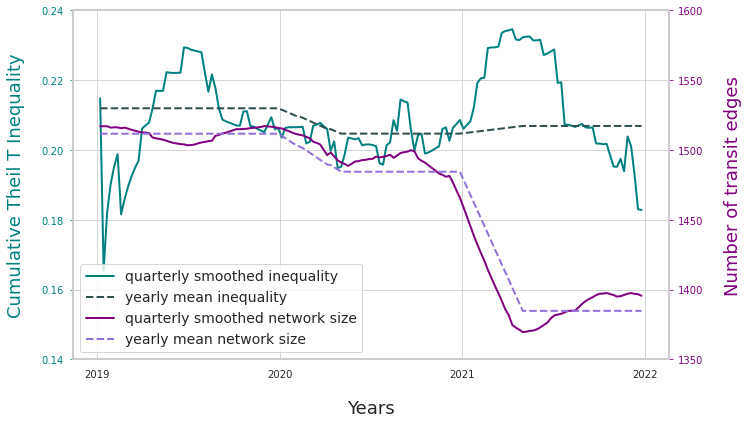

In [47]:
fig,ax = plt.subplots(figsize=(10.5,6))

l1 = ax.plot(dates_data, theil_ineq_data, color='teal', label='quarterly smoothed inequality')
# ineq_over_time.plot('date', "('theil_inequality_yearly', '')", ax=ax, style='-.', label='yearly base inequality').legend(loc='lower left')
l2 = ax.plot(dates_data, theil_ineq_mean_data, '--', color='darkslategray', label='yearly mean inequality')

now = datetime.datetime(2019,1,1,0,0,0)
then = datetime.datetime(2023,1,1,0,0,0)
years = mdates.drange(now,then,datetime.timedelta(days=366))
ax.set_xticks(years)

ax2 = ax.twinx()
l3 = ax2.plot(dates_data, size_data, color='purple', label='quarterly smoothed network size')
# ineq_over_time.plot('date', "('size_yearly', '')", ax=ax2, color='purple', style='-.', label='yearly base network size').legend(loc='upper right')
l4 = ax2.plot(dates_data, mean_size_data, '--', color='mediumpurple', label='yearly mean network size')

lns = l1+l2+l3+l4
labs = [l.get_label() for l in lns]
ax.legend(lns, labs, loc=3)
ax.xaxis.labelpad = 20
ax2.grid(None)
# ax.set_title("Egalitarian reward and PTN size over time\nquarterly smoothed")
ax.set_ylabel("Cumulative Theil T Inequality")
ax.set_ylim(0.14,0.24)
ax2.set_ylabel("Number of transit edges", labelpad=20)
ax2.set_ylim(1350,1600)
ax.set_xlabel("Years")

ax.yaxis.label.set_color('teal')
ax.tick_params(axis='y', colors='teal')

ax2.yaxis.label.set_color('purple')
ax2.tick_params(axis='y', colors='purple')

fig.tight_layout()

# fig.savefig('plots/ams_analysis/inequality_size_over_years.png')
# fig.savefig('/home/rico/Documents/thesis/paper/overleaf/62a466789b2183065a639cda/content-media/inequality_size_over_years.png')
# fig.savefig('/home/rico/Documents/thesis/paper/overleaf/62a466789b2183065a639cda/content-media/inequality_size_over_years.svg')



In [48]:
127/1511

0.08405029781601589

## Correlation metric over non-western/western over time

In [49]:
nw_to_w_trend[nw_to_w_trend.metric == 'avg_tt']

,date,metric,slope,intercept,r_value,p_value,std_err,year,month,quarter,size
1,2019-01-07,avg_tt,-6.104845,27.555600,-0.272682,5.858667e-09,1.028034,2019,1,1,1517
4,2019-01-14,avg_tt,2.176464,13.055618,0.124105,9.083280e-03,0.830537,2019,1,1,1517
6,2019-01-21,avg_tt,-6.160150,27.547670,-0.274398,4.661595e-09,1.030340,2019,1,1,1517
10,2019-01-28,avg_tt,-6.086131,27.543073,-0.272014,6.401755e-09,1.027603,2019,1,1,1513
13,2019-02-04,avg_tt,-6.119169,27.534452,-0.272766,5.793551e-09,1.030103,2019,2,1,1517
...,...,...,...,...,...,...,...,...,...,...,...
453,2021-11-29,avg_tt,-5.696380,27.634737,-0.213276,6.237839e-06,1.245422,2021,11,4,1395
456,2021-12-06,avg_tt,0.191864,15.090947,0.008200,8.641256e-01,1.120532,2021,12,4,1396
461,2021-12-13,avg_tt,2.199445,11.277693,0.112203,1.896379e-02,0.933929,2021,12,4,1387
464,2021-12-20,avg_tt,2.667345,10.427095,0.136217,4.334798e-03,0.930112,2021,12,4,1382


In [53]:
sum(nw_to_w_trend[nw_to_w_trend.metric == 'avg_tt']['slope']>0)

25

In [ ]:
def plot_metric_correlation_nw_w(metric: str, metric_name: str, loc=None):

    considered_trend = nw_to_w_trend[nw_to_w_trend.metric == metric]
    considered_trend_means = considered_trend.groupby('year').mean()
    considered_trend = pd.merge(considered_trend, considered_trend_means, on='year', suffixes=['','_yearly_means'])

    fig,ax = plt.subplots(figsize=(10,6))

    ineq_over_time_smoothed = ineq_over_time.rolling('120D').mean()
    dates_data = ineq_over_time_smoothed.index
    size_data = ineq_over_time_smoothed['size']
    mean_size_data = ineq_over_time_smoothed.size_mean
    r_value_data = considered_trend.r_value
    r_value_yearly_data = considered_trend.r_value_yearly_means

    # l1 = ax.plot(dates_data, r_value_data, color='teal', label='R2 value')
    l2 = ax.plot(dates_data, r_value_yearly_data, '--', color='darkslategray', label='yearly mean R2 value')
    s1 = ax.scatter(dates_data, r_value_data,
                    c=[p < 0.05 for p in considered_trend.p_value],
                    cmap='flag',
                    s=40)

    ax.set_xticks(years)

    ax2 = ax.twinx()

    l3 = ax2.plot(dates_data, size_data, color='purple', label='quarterly smoothed network size')
    l4 = ax2.plot(dates_data, mean_size_data, '--', color='mediumpurple', label='yearly mean network size')

    ax2.yaxis.label.set_color('purple')
    ax2.tick_params(axis='y', colors='purple')

    lns = l2+l3+l4
    labs = [l.get_label() for l in lns]
    legend1 = ax.legend(lns, labs, loc=loc if loc else 0)
    ax.xaxis.labelpad = 20
    ax2.grid(None)

    legend2 = ax.legend(s1.legend_elements()[0], ['$\\mathdefault{p>0.05}$', '$\\mathdefault{p<0.05}$'],
                        loc="lower left", title="Significance")
    ax.add_artist(legend1)
    ax.add_artist(legend2)

    ax.set_ylabel("R2 value")
    ax.set_ylim(-0.6,0.5)
    ax2.set_ylabel("Number of transit edges")
    ax2.set_ylim(1350,1600)
    ax.set_xlabel("Years")

    # ax.set_title(f"Correlation of % western population and {metric_name} over time")
    fig.tight_layout()
    return fig, ax

fig, ax = plot_metric_correlation_nw_w('avg_tt', metric_name="avg. travel time")
# fig.savefig('plots/ams_analysis/correlation_size_over_years_travel_time.svg')
# fig.savefig('plots/ams_analysis/correlation_size_over_years_travel_time.png')
# fig.savefig('/home/rico/Documents/thesis/paper/overleaf/62a466789b2183065a639cda/content-media/correlation_size_over_years_travel_time.png')
# fig.savefig('/home/rico/Documents/thesis/paper/overleaf/62a466789b2183065a639cda/content-media/correlation_size_over_years_travel_time.svg')
plt.show()
#
fig, ax = plot_metric_correlation_nw_w('avg_hops', metric_name="avg. hops")
# fig.savefig('plots/ams_analysis/correlation_size_over_years_hops.svg')
# fig.savefig('plots/ams_analysis/correlation_size_over_years_hops.png')
# fig.savefig('/home/rico/Documents/thesis/paper/overleaf/62a466789b2183065a639cda/content-media/correlation_size_over_years_hops.png')
# fig.savefig('/home/rico/Documents/thesis/paper/overleaf/62a466789b2183065a639cda/content-media/correlation_size_over_years_hops.svg')
plt.show()
#
fig, ax = plot_metric_correlation_nw_w('thr_15min_pois', metric_name="15 min COM", loc='lower center')
# fig.savefig('plots/ams_analysis/correlation_size_over_years_com.svg')
# fig.savefig('plots/ams_analysis/correlation_size_over_years_com.png')
# fig.savefig('/home/rico/Documents/thesis/paper/overleaf/62a466789b2183065a639cda/content-media/correlation_size_over_years_com.png')
# fig.savefig('/home/rico/Documents/thesis/paper/overleaf/62a466789b2183065a639cda/content-media/correlation_size_over_years_com.svg')
plt.show()

In [ ]:



considered_trend = nw_to_w_trend[nw_to_w_trend.metric == 'avg_tt']

## Metric over time

In [ ]:
considered_stat = complete_stats[complete_stats.metric=='avg_tt']

In [ ]:
considered_metrics_only = considered_stat[[nb for nb in considered_stat.columns if 'BU' in nb]].copy()
considered_metrics_only['date'] = considered_stat.date
considered_metrics_only = considered_metrics_only.set_index('date', drop=False)
nbs = considered_metrics_only.columns
considered_metrics_only['std_value'] = considered_metrics_only[nbs].std(axis=1)
considered_metrics_only['mean_value'] = considered_metrics_only[nbs].median(axis=1)

considered_metrics_only

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))
ax.plot(considered_metrics_only.date, considered_metrics_only.mean_value, label='avg. of per-neighborhood avg. travel times')
ax.fill_between(considered_metrics_only.date,
                considered_metrics_only.mean_value - considered_metrics_only.std_value,
                considered_metrics_only.mean_value + considered_metrics_only.std_value,
                alpha=0.2)

ax.set_xticks(years)

ax.set_ylabel('Avg. travel time')
ax.set_xlabel('Year')

ax.legend()

In [ ]:
years

In [ ]:
considered_stat.date